<a href="https://colab.research.google.com/github/paulorfbr/tensor_flow_course_deep_learning/blob/gan/Generative_Adversarial_Networks_(GANs)_TF2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

tf.get_logger().setLevel('ERROR')

import warnings
warnings.filterwarnings('ignore')

In [ ]:
print(tf.__version__)

2.14.0


In [ ]:
import tensorflow as tf
from keras.layers import Input, Lambda, Dense, Flatten
from keras.layers import AveragePooling2D, MaxPooling2D
from keras.layers import Input, Conv2D, Dense, Flatten, Dropout, GlobalMaxPooling2D, LeakyReLU, MaxPooling2D, BatchNormalization
from keras.models import Model
from keras.optimizers import Adam, SGD
from keras.models import Model, Sequential
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image

import keras.backend as K
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

In [ ]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
#map to -1, +1
x_train, x_test = x_train / 255.0 * 2 -1, x_test / 255.0 * 2 -1
print('x_train shape:', x_train.shape)

x_train shape: (60000, 28, 28)


In [ ]:
#Flatten the data
N, H, W = x_train.shape
D = H * W
x_train = x_train.reshape(-1, D)
x_test = x_test.reshape(-1, D)


In [ ]:
#dimensionality of latent space
latent_dim = 100

In [ ]:
#generator architecture
def build_generator(latent_dim):
  i = Input(shape=(latent_dim,))
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(i)
  x = BatchNormalization(momentum=0.8)(x)
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(i)
  x = BatchNormalization(momentum=0.8)(x)
  x = Dense(1024, activation=LeakyReLU(alpha=0.2))(i)
  x = BatchNormalization(momentum=0.8)(x)
  x = Dense(D, activation='tanh')(x)

  model = Model(i, x)
  return model

In [ ]:
#discriminator architecture
def build_discriminator(img_size):
  i = Input(shape=(img_size,))
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(i)
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(x)
  x = Dense(1, activation='sigmoid')(x)

  model = Model(i, x)
  return model

In [ ]:
discriminator = build_discriminator(D)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

generator = build_generator(latent_dim)

#create input to represent noise sample from latent space
z = Input(shape=(latent_dim,))

#pass noise through generator to get an image
img = generator(z)

#make sure discriminator is frozen (train only generator)
discriminator.trainable = False

#the true output is fake, but we label them as real
fake_pred = discriminator(img)

#combined model
combined_model = Model(z, fake_pred)
combined_model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])


In [ ]:
#train GAN
batch_size = 32
epochs = 30000
sample_period = 200 #generate and save some data

#create batch labels to use when train
ones = np.ones(batch_size)
zeros = np.zeros(batch_size)

#store losses
d_losses = []
g_losses = []

#place to store generated images
if not os.path.exists('gan_images'):
  os.makedirs('gan_images')



In [ ]:
#sample images
def sample_images(epoch):
  rows, cols = 5, 5
  noise = np.random.randn(rows*cols, latent_dim)
  imgs = generator.predict(noise)

  #rescale 0, 1
  imgs = 0.5 * imgs + 0.5

  fig, axs = plt.subplots(rows, cols)
  idx = 0
  for i in range(rows):
    for j in range(cols):
      axs[i,j].imshow(imgs[idx].reshape(H, W), cmap='gray')
      axs[i,j].axis('off')
      idx += 1
  fig.savefig("gan_images/%d.png" % epoch)
  plt.close()

In [ ]:
#main training loop
for epoch in range(epochs):
  #train discriminator
  idx = np.random.randint(0, x_train.shape[0], batch_size)
  real_imgs = x_train[idx]

  #generate fake images
  noise = np.random.randn(batch_size, latent_dim)
  fake_imgs = generator.predict(noise)

  #train discriminator
  d_loss_real, d_acc_real = discriminator.train_on_batch(real_imgs, ones)
  d_loss_fake, d_acc_fake = discriminator.train_on_batch(fake_imgs, zeros)

  d_loss = 0.5 * (d_loss_real + d_loss_fake)
  d_acc = 0.5 * (d_acc_real + d_acc_fake)

  #train generator
  noise = np.random.randn(batch_size, latent_dim)
  g_loss = combined_model.train_on_batch(noise, ones)

  d_losses.append(d_loss)
  g_losses.append(g_loss)

  if epoch % 100 == 0:
    print(f"epoch: {epoch+1/epochs}, d_loss: {d_loss:.2f}, d_acc: {d_acc:.2f}")

  if epoch % sample_period == 0:
    sample_images(epoch)



Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 15ms/step
epoch: 25100.000033333334, d_loss: 0.39, d_acc: 0.83
1/1 [==============================] - 0s 15ms/step
epoch: 25200.000033333334, d_loss: 0.49, d_acc: 0.81
1/1 [==============================] - 0s 28ms/step
epoch: 25300.000033333334, d_loss: 0.30, d_acc: 0.88
1/1 [==============================] - 0s 16ms/step
epoch: 25400.000033333334, d_loss: 0.42, d_acc: 0.78
1/1 [==============================] - 0s 16ms/step
epoch: 25500.000033333334, d_loss: 0.45, d_acc: 0.80
1/1 [==============================] - 0s 17ms/step
epoch: 25600.000033333334, d_loss: 0.41, d_acc: 0.86
1/1 [==============================] - 0s 16ms/step
epoch: 25700.000033333334, d_loss: 0.38, d_acc: 0.80
1/1 [==============================] - 0s 15ms/step
epoch: 25800.000033333334, d_loss: 0.29, d_acc: 0.89
1/1 [==============================] - 0s 16ms/step
epoch: 25900.000033333334, d_loss: 0.33, d_acc: 0.84
1/1 

In [ ]:
!ls gan_images

0.png	   12800.png  16000.png  19000.png  22000.png  25000.png  2800.png   4200.png  7400.png
10000.png  13000.png  1600.png	 19200.png  2200.png   25200.png  28200.png  4400.png  7600.png
1000.png   13200.png  16200.png  19400.png  22200.png  25400.png  28400.png  4600.png  7800.png
10200.png  13400.png  16400.png  19600.png  22400.png  25600.png  28600.png  4800.png  8000.png
10400.png  13600.png  16600.png  19800.png  22600.png  25800.png  28800.png  5000.png  800.png
10600.png  13800.png  16800.png  20000.png  22800.png  26000.png  29000.png  5200.png  8200.png
10800.png  14000.png  17000.png  2000.png   23000.png  2600.png   29200.png  5400.png  8400.png
11000.png  1400.png   17200.png  200.png    23200.png  26200.png  29400.png  5600.png  8600.png
11200.png  14200.png  17400.png  20200.png  23400.png  26400.png  29600.png  5800.png  8800.png
11400.png  14400.png  17600.png  20400.png  23600.png  26600.png  29800.png  6000.png  9000.png
11600.png  14600.png  17800.png  20600.png  

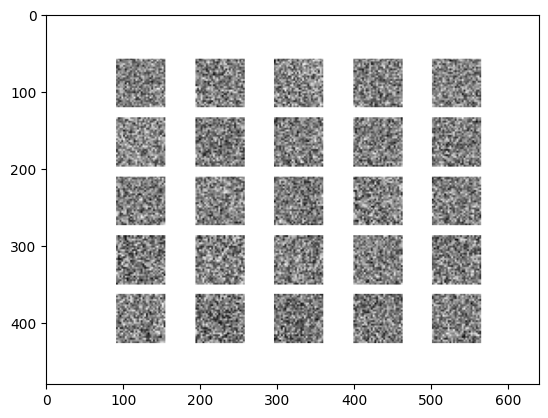

In [ ]:
from skimage.io import imread
a = imread('gan_images/0.png')
plt.imshow(a)

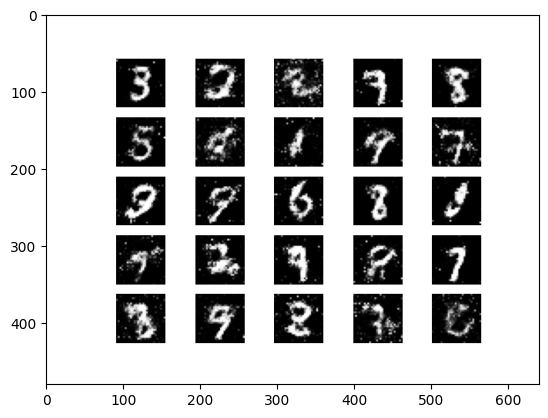

In [ ]:
from skimage.io import imread
a = imread('gan_images/10000.png')
plt.imshow(a)

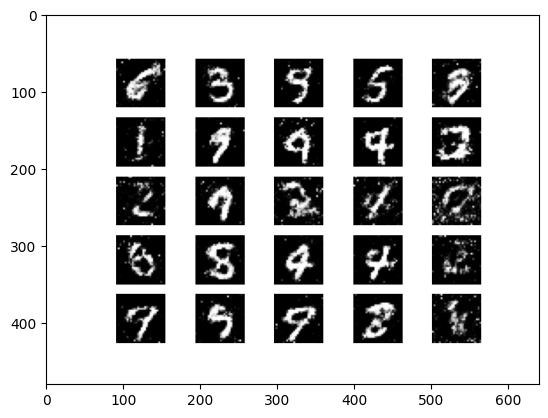

In [ ]:
from skimage.io import imread
a = imread('gan_images/20000.png')
plt.imshow(a)

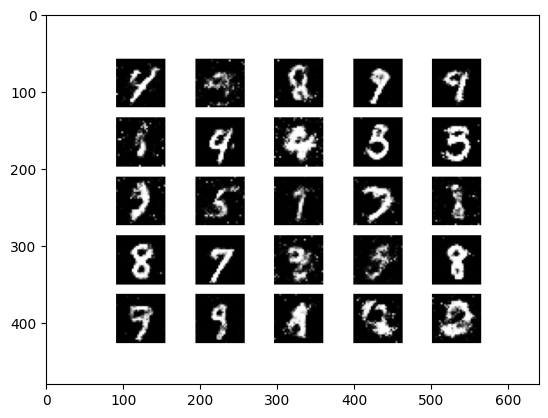

In [ ]:
from skimage.io import imread
a = imread('gan_images/29800.png')
plt.imshow(a)